In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import (
    BrownianProcess, BrownianAuxProcess, BrownianBridgeProcess,
    OUProcess, OUAuxProcess, OUBridgeProcess
)
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLPSmall
from neuralbridge.models.neurb import NeuralBridge
from neuralbridge.utils.plotting import plot_sample_path

# Guiding Brownian bridge with another Brownian process
We use a Brownian bridge with constant drift as the target bridge, and approximate it by learning from another Brownian bridge without drift, specifically:
$$
\mathrm{d}X_t = \gamma\mathrm{d}t + \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\star}_t = \left\{\gamma + \frac{v - X^{\star}_t - \gamma * (T - t)}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t = \left\{\frac{v - X^{\star}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
And the auxiliary and guided processes are:
$$
\mathrm{d}\tilde{X}_t = \sigma\mathrm{d}W_t \\
\mathrm{d}X^{\circ}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Therefore, if the neural guided process is constructed as:
$$
\mathrm{d}X^{\diamond}_t = \left\{\gamma + \frac{v - X^{\circ}_t}{T-t} + \sigma\nu_{\theta}(t, X^{\diamond}_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
We can expect:
$$
\nu_{\theta^*}(t, x) = -\frac{\gamma}{\sigma}
$$

In [42]:
dim = 1
T = 1.0
dt = 1. / 250
dtype = jnp.float32

gamma = 1.0
sigma = 1.0

seed = 42
u = jnp.array([0.0], dtype=dtype)
v = jnp.array([0.0], dtype=dtype)

In [43]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

ori_proc = BrownianProcess(gamma, sigma, T, dim, dtype)
aux_proc = BrownianAuxProcess(0.0, sigma, T, dim, dtype)
bridge_proc = BrownianBridgeProcess(gamma, sigma, score_fn=None, v=v, T=T, dim=dim, dtype=dtype)

guided_bridge_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype) * 1e-10,
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

In [44]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(20, 20, 20),
    norm=None,
    activation="tanh"
)

In [45]:
train_config = {
    "save_name": "brownian_bridge_tanh",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 64,
    "n_iters": 200,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 100
}

In [46]:
neural_bridge = NeuralBridge(guided_bridge_proc, neural_net, train_config)

In [47]:
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
neural_bridge.initialize_path_solver(wiener_proc)
losses = neural_bridge.train_neural_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/brownian_bridge_tanh
INFO:root:Loading pretrained model from the last epoch


<Axes: title={'center': 'Brownian Bridges'}, xlabel='$t$', ylabel='$x$'>

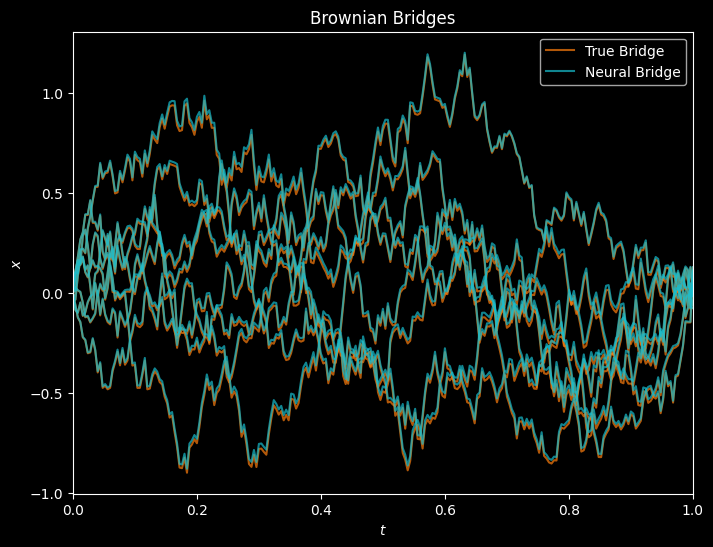

In [48]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=8)

bridge_solver = Euler(bridge_proc, wiener_proc)
bridge_path = bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=8)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_sample_path(bridge_path, ax=ax, color="tab:orange", label="True Bridge", linewidth=1.5)
plot_sample_path(neural_bridge_path, ax=ax, color="tab:cyan", label="Neural Bridge", linewidth=1.5, title="Brownian Bridges")

# Guiding OU bridge with a Brownian process
We then use a standard Brownian motion as the auxiliary process to approach the Ornstein–Uhlenbeck bridge, specifically:
$$
\mathrm{d}X_t = -\gamma \cdot X_t \mathrm{d}W_t + \sigma \mathrm{d}W_t \\
\mathrm{d}X^{\star}_t = -\gamma\left[\frac{v}{\sinh(-\gamma(T-t))} - \frac{X^{\star}_t}{\tanh(-\gamma(T-t))}\right]\mathrm{d}t + \sigma\mathrm{d}W_t
$$
See _Constraint Ornstein-Uhlenbeck bridges, Alain Mazzolo_ for derived OU bridge. Then we choose a Brownian motion as the auxiliary process:
$$
\mathrm{d}\tilde{X}_t = \sigma \mathrm{d}W_t \\
\mathrm{d}X^{\circ}_t = \left\{-\gamma\cdot X^{\circ}_t + \frac{v-X^{\circ}_t}{T-t}\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
Therefore, if the neural guided process is constructed as:
$$
\mathrm{d}X^{\diamond}_t = \left\{-\gamma\cdot X^{\diamond}_t +\frac{v - X^{\diamond}_t}{T-t} + \sigma\nu_{\theta}(t, X^{\diamond}_t)\right\}\mathrm{d}t + \sigma\mathrm{d}W_t
$$
We can expect:
$$
\nu_{\theta^*}(t, x) = \frac{1}{\sigma}\left\{-\gamma\left[\frac{v}{\sinh(-\gamma(T-t))} - \frac{x}{\tanh(-\gamma(T-t))}\right] - \frac{v-x}{T-t} + \gamma\cdot x\right\}
$$

In [49]:
dim = 1
T = 1.0
dt = 1. / 250
dtype = jnp.float32

gamma = 1.0
sigma = 1.0

seed = 42
u = jnp.array([0.0], dtype=dtype)
v  = jnp.array([0.0], dtype=dtype)

In [50]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

ori_proc = OUProcess(gamma, sigma, T, dim, dtype)
aux_proc = OUAuxProcess(0.0, sigma, T, dim, dtype)
bridge_proc = OUBridgeProcess(gamma, sigma, score_fn=None, v=v, T=T, dim=dim, dtype=dtype)

guided_bridge_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    u=u,
    v=v,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype) * 1e-10,
    ts=jnp.arange(0, T + dt, dt, dtype=dtype),
    ode_solver_kernel=ode_solver_kernel
)

In [51]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(20, 20, 20),
    norm=None,
    activation="tanh"
)

In [52]:
train_config = {
    "save_name": "ou_bridge_tanh",
    "seed": seed,
    "learning_rate": 2e-4,
    "batch_size": 64,
    "n_iters": 200,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 200
}

In [53]:
model = NeuralBridge(guided_bridge_proc, neural_net, train_config)

In [54]:
wiener_proc = WienerProcess(T, dt, dim, dtype, t_scheme)
model.initialize_path_solver(wiener_proc)
losses = model.train_neural_bridge(u=u, v=v, mode="pretrained")

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.11/site-packages/orbax/checkpoint/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(
INFO:root:Checkpoint loaded from /Users/vbd402/Documents/Projects/neuralbridge/assets/ckpts/neuralbridge/ou_bridge_tanh
INFO:root:Loading pretrained model from the last epoch


<Axes: title={'center': 'OU Bridges'}, xlabel='$t$', ylabel='$x$'>

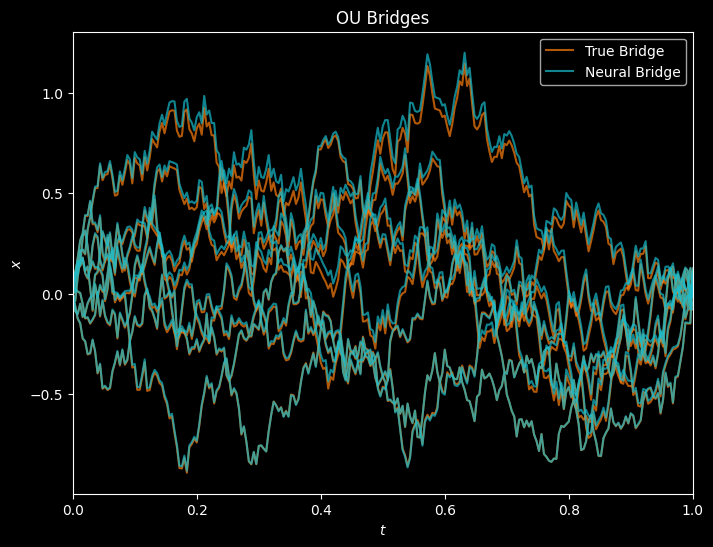

In [55]:
neural_bridge_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=8)

bridge_solver = Euler(bridge_proc, wiener_proc)
bridge_path = bridge_solver.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=8)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_sample_path(bridge_path, ax=ax, color="tab:orange", label="True Bridge", linewidth=1.5)
plot_sample_path(neural_bridge_path, ax=ax, color="tab:cyan", label="Neural Bridge", linewidth=1.5, title="OU Bridges")